In [11]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import seaborn as sns

In [12]:
# Time limit for optimization function and M value for Big M constraint
time = 100
M = 200

In [13]:
# Reading in train and test files 
df= pd.read_csv('training_data.csv')
df_test = pd.read_csv('test_data.csv')

In [17]:
df

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,7.296352,0.210132,-0.193059,2.033908,-0.832887,0.049040,-0.197864,-1.885529,-2.526842,-0.826903,...,0.555085,-2.099135,-0.411719,1.053645,-0.172623,-1.207709,0.748914,-1.343144,-0.696000,0.525172
246,6.385276,-0.039047,-0.021366,1.040784,-3.435317,-0.419417,0.293139,-0.165674,-0.357788,-0.943576,...,-0.564113,-1.721975,-0.556074,0.028959,0.594509,-1.010988,-0.205257,-0.148502,-0.656065,0.140523
247,7.835373,0.091237,0.473698,0.051832,0.721924,0.337938,1.322324,-0.605442,0.428120,0.003276,...,0.348330,0.099530,0.019925,1.121458,1.901447,-0.431072,-0.124469,-0.084185,-0.200143,0.840786
248,4.788263,-1.407003,0.510886,-2.077584,-0.438144,2.225628,0.165129,-1.335051,1.348180,-0.031812,...,-1.076265,1.303594,-1.458794,1.172178,0.451014,0.572106,-3.660368,-0.052251,0.543762,0.274006


In [14]:
# Creating X and y matrix for test data  -- used in question 3
y_test = df_test['y']
X_test = df_test.drop(columns='y', axis=1) 

y_test_matrix =np.array(y_test)

# X_test_matrix also accounts for the column of ones, so total columns are 51 -- use this for all future calculations
X_test_matrix = np.array(X_test)
X_test_matrix = np.c_[np.ones((len(X_test),1)),X_test_matrix]

## Cross-validation - Question 2

In [15]:
# Write function to create 10 random folds from df
def cross_validation_func (cvfolds, df):
    for f in range(1,cvfolds+1):
        np.random.seed(0)
        indexes = np.random.choice(len(df),int(len(df)/cvfolds), replace= False)
    return indexes   

In [16]:
# Write function for optimization that runs the k-fold cross validation and returns SSE values for different values of k
def optimization_func (df, k, cvfolds, M):
    mean_squared_error=[] # initialize list to store SSE

    for value in k:
        squared_error=[] # stores 10 error values for 10 folds at each k everytime time loop is run 
        for x in range(cvfolds):
            indexes = cross_validation_func(cvfolds,df) # call cross validation function to create random indexes
            
            # create matrix for validation set 
            validation_set = df.iloc[indexes]
            validation_set = validation_set.drop(columns='y', axis=1)
            validation_matrix = np.array(validation_set)
            validation_matrix= np.c_[np.ones((len(validation_set),1)),validation_set]
            
            validation_y = df['y'].iloc[indexes]
            validation_y = list(validation_y)
            
            # create matrix for training set 
            training_set = df.drop(indexes, axis=0)
            training_set = training_set.drop(columns='y', axis=1)
            training_y = df['y'].drop(indexes, axis=0)
            training_y = list(training_y)
            

            m = len(training_set.columns)
            
            # Following is the optimization section of the function
            # Creating the X and y matrix 
            y= np.array(training_y)
            X= np.array(training_set)
            X= np.c_[np.ones((len(training_set),1)),training_set]

            X_T = X.transpose()
            y_T= y.transpose()

            Q = np.zeros([(2*m+1),(2*m+1)])


            XT_X = X_T @ X

            # Inserting XT_X into top left corner of Q
            for i in range(51):
                for j in range(51):
                    Q[i,j]= XT_X[i,j] # This creates the quadratic part of the objective
                    
            # Writing the linear part of the objective
            linear_obj = -2*y_T @ X 
            obj = np.zeros((2*m+1))
            obj[0: m+1] = linear_obj
            
            # Initialize the constraint matrix A
            A=np.zeros((2*m+1,2*m+1))
            A[0,m+1:2*m+1] = [1]*m  # Constraint for picking the number of betas

            # Filling A[1:50]
            for i in range(1,m+1):
                A[i,i] = 1
                A[i, i+m] = M  # Constraint for setting upper limit on betas 


            # Filling A[51:100]
            for i in range(m+1,2*m+1):
                A[i,i-m] = 1
                A[i, i] = -M # Constraint for setting lower limit on betas 

            # Create the b vector
            b= np.zeros(2*m+1)
            b[0] = value

            sense = ['<']+['>']*m + ['<']*m # specify the signs on the constraints 
            vtype=['C']*(m+1) + ['B']*m  # specify the type of variable -- all betas are continuous variables, all z are binary
            lb = -M  # set lower limit on betas as gurobi automatically takes that as 0
            
            # Set up the optimization model
            olsMod = gp.Model()
            olsMod_x = olsMod.addMVar(len(obj), vtype=vtype, lb=lb)
            olsMod_con = olsMod.addMConstrs(A, olsMod_x, sense, b)
            olsMod.setMObjective(Q,obj,0,sense=gp.GRB.MINIMIZE)

            olsMod.Params.OutputFlag = 0 
            olsMod.Params.timelimit = time # time is specified at top of the notebook

            olsMod.optimize()
            
            betas= olsMod_x.x # store beta values in a list
            
            # Take dot product of beta values with the x values in validation matrix to get predicted y
            y_pred = np.dot(validation_matrix, betas[:51]) 
            
            # Get sum of squared error  
            error_sq = sum((y_pred - validation_y)**2)
            
            squared_error.append(error_sq)
        mean_squared_error.append(sum(squared_error)) 
    # return average SSE for each value of k
    return mean_squared_error 
            
 

In [7]:
# We want to run k-fold cross validation for k values = 5,10,15,20,25,30,35,40,45,50
k= list(range(5,51,5))

In [ ]:
# call optimization function, specify df, k, cvfolds=10, M=200
returned_vals = optimization_func(df, k, 10, 200)

Academic license - for non-commercial use only - expires 2022-08-22
Using license file /Users/junsu/gurobi.lic


/var/folders/gp/5lrc5h3s21d02v2rsj713dxw0000gn/T/ipykernel_65869/3994433521.py:2: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  returned_vals = optimization_func(df, k, 10, 200)



Interrupt request received


In [9]:
# Create df to store SSE values for each k
columns = ['k-value', 'SSE']
sse_df = pd.DataFrame(zip(k,returned_vals), columns=columns)
sse_df = sse_df.set_index('k-value')

In [10]:
sse_df

,SSE
k-value,
5,755.692655
10,619.053973
15,720.335624
20,797.972161
25,856.995553
30,861.232576
35,937.382219
40,939.414678
45,941.679342


Text(0, 0.5, 'SSE')

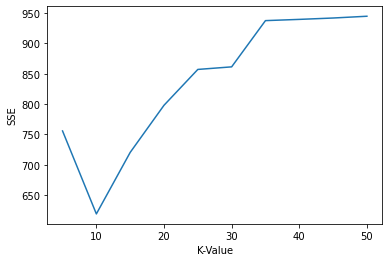

In [11]:
plt.plot(k, sse_df['SSE'])
plt.xlabel('K-Value')
plt.ylabel('SSE')

From the graph, we can clearly see that k=10 has the least SSE. Therefore, the best value of **k = 10**

In [12]:
best_k = sse_df['SSE'].idxmin()

In [13]:
best_k

10

## Question 3

Use training data with the best value of k to train the model, then use the beta values to predict on the test set

In [ ]:
# Creating the X and y matrix for train data 
y= np.array(df['y'])
X= np.array(df.drop(columns='y'))
X=np.c_[np.ones((len(df),1)),X]

X_T = X.transpose()
y_T= y.transpose()


XT_X = X_T @ X

m = len(df.drop(columns='y').columns)


# Filling Q matrix with XT_X

Q = np.zeros([2*len(df.drop(columns='y').columns)+1,2*len(df.drop(columns='y').columns)+1])
Q[0:51,0:51]= XT_X


linear_obj = -2*y_T @ X 
obj = np.zeros((2*m+1))
obj[0: m+1] = linear_obj

In [ ]:
A=np.zeros((2*m+1,2*m+1))
A[0,m+1:2*m+1] = [1]*m

# Filling A[1:50]
for i in range(1,m+1):
    A[i,i] = 1
    A[i, i+m] = M

    
# Filling A[51:100]
for i in range(m+1,2*m+1):
    A[i,i-m] = 1
    A[i, i] = -M

b= np.zeros(2*m+1)
b[0] = best_k ## INSERT HERE to try with another value of k

sense = ['<']+['>']*m + ['<']*m
vtype=['C']*(m+1) + ['B']*m
lb = -M

In [ ]:
olsMod = gp.Model()
olsMod_x = olsMod.addMVar(len(obj), vtype=vtype, lb=lb)
olsMod_con = olsMod.addMConstrs(A, olsMod_x, sense, b)
olsMod.setMObjective(Q,obj,0,sense=gp.GRB.MINIMIZE)

olsMod.Params.OutputFlag = 0 

olsMod.optimize()

In [ ]:
betas_training = olsMod_x.x

In [ ]:
betas_training

In [19]:
betas_list = ['X0'] + list(df.drop(columns='y').columns)
# betas_list
betas_df=pd.DataFrame(zip(betas_list, betas_training),columns=['X','beta'])
betas_df = betas_df[betas_df['beta'] != 0]
betas_df

,X,beta
0,X0,0.972524
9,X9,-2.308207
15,X15,-0.518326
16,X16,-0.204162
23,X23,-1.559143
24,X24,0.866973
26,X26,-1.311919
34,X34,0.408165
45,X45,1.781475
47,X47,0.887383


/Users/junsu/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='X', ylabel='beta'>

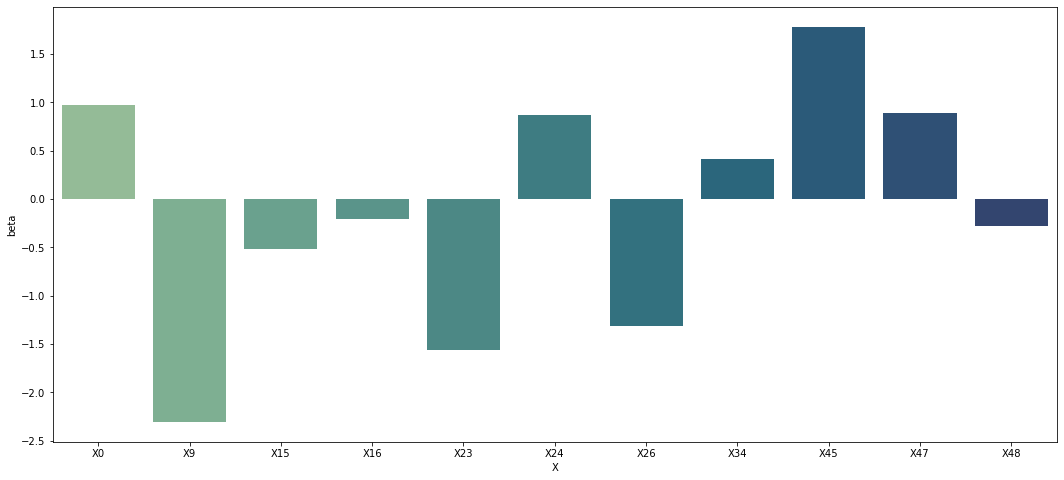

In [20]:
plt.figure(figsize=(18, 8))
sns.barplot(betas_df['X'], betas_df['beta'], palette='crest')


In [21]:
# Use betas to predict y values on the test data
y_pred_test = np.dot(X_test_matrix, betas_training[:51])
y_pred_test

array([ 6.17985878,  5.09524299,  3.28559532,  3.75848539, -0.33297526,
       -5.14273683, -3.14454357, -1.23806288,  1.38511093, -0.44173854,
       -1.69500225,  2.73035027,  0.74744903, -0.97192232, -0.68681528,
        8.04522381, -7.94698471,  3.89063974, -4.58142919, -3.21992082,
       -2.16211454,  3.21686318, -3.19810533,  0.19740731, -2.35988844,
       -0.41999885, -1.9125216 , -3.32418587, -3.14170972, -3.55379324,
       -1.80842543, -0.37134301,  1.8670808 ,  5.04927886, -1.80005614,
        3.09427675,  4.38154309,  2.6988627 ,  1.6132886 ,  5.97584637,
       -1.1973583 ,  5.2232542 , -5.84899891, -1.14461528,  4.51802998,
        4.18774866,  4.12046008,  0.61483809,  1.95723246, -1.54904383])

In [22]:
error_sq = sum((y_pred_test - list(y_test_matrix))**2)
cv_mse = mean_squared_error(y_pred_test, list(y_test_matrix))

print('The SSE on the test data is: ', round(error_sq,3))
print('The MSE on the test data is: ', round(cv_mse,3))

The SSE on the test data is:  116.827
The MSE on the test data is:  2.337


## Question 4 - LASSO CV

In [23]:
# Use scikit learn to find best value of lambda using LassoCV
reg = LassoCV(cv=10, random_state=0).fit(X,y)

In [24]:
# keep the best hyper-parameter for the penalty, alpha
alpha = reg.alpha_
print('The amount of penalty from CV is: ', round(alpha,5) )

The amount of penalty from CV is:  0.07639


In [25]:
# Now create Lasso model using the best value of alpha
# Bring the alpha previously identified into a Lasso model

clf = linear_model.Lasso(alpha=alpha)
clf.fit(X,y)

Lasso(alpha=0.07638765995113514)

In [26]:
# Predict using lasso model on the test set
y_pred_lasso = clf.predict(X_test_matrix)

In [27]:
# Compute the SSE and MSE
lasso_sse = sum((y_pred_lasso - list(y_test_matrix) )**2)
MSE = mean_squared_error(y_pred_lasso, list(y_test_matrix))

print('The SSE on test data using lasso is: ', round(lasso_sse,3))
print('The MSE on test data using lasso is: ', round(MSE,3))

The SSE on test data using lasso is:  117.482
The MSE on test data using lasso is:  2.35


In [28]:
# Comparing LASSO CV and our cross validation function 
errors = [error_sq, lasso_sse]

index= ['CV model', 'LASSO model']
cols=['SSE']
df2= pd.DataFrame(errors, index=index, columns= cols)
df2

,SSE
CV model,116.827198
LASSO model,117.481738


Based on the errors in the table above, we can say that the CV model we wrote performed better than the LASSO model